In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)
from src.data_models.caravanify import Caravanify, CaravanifyConfig 

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroDataModule

---

## Testing Caravanify

In [3]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/timeseries/csv",
    gauge_id_prefix="CH",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)


caravan = Caravanify(config)
# ids_for_training = [
#     "CH_4011",
#     "CH_5009",
# ]
ids_for_training = caravan.get_all_gauge_ids()[:5]

print(f"Total number of stations: {len(ids_for_training)}")

caravan.load_stations(ids_for_training)


# Get data
ts_data = caravan.get_time_series()  # MultiIndex: (gauge_id, date)
static_data = caravan.get_static_attributes()  # Columns merged from enabled attributes

Total number of stations: 5


In [4]:
ts_data["date"] = pd.to_datetime(ts_data["date"])

# Now we can get the day of year using dt accessor
ts_data["julian_day"] = ts_data["date"].dt.dayofyear

# Get column names excluding specific columns
ts_columns = ts_data.columns
ts_columns = [
    col for col in list(ts_columns) if col not in ["gauge_id", "date"]
]

In [5]:
statics_to_keep = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

static_columns = static_data.columns
static_columns = [col for col in list(static_columns) if col in statics_to_keep]

static_data = static_data[static_columns]
static_data

,gauge_id,area,cly_pc_sav,ele_mt_sav,slp_dg_sav,aridity_ERA5_LAND,aridity_FAO_PM,frac_snow,high_prec_dur,high_prec_freq,p_mean
0,CH_2009,701.274189,14.506965,1565.340147,248.671068,0.999746,0.258537,0.386329,1.134021,0.030118,4.954752
1,CH_2011,1566.180595,14.634048,2081.147355,247.628593,0.559558,0.235603,0.479000,1.223587,0.034089,4.197982
2,CH_2016,811.489711,19.279472,536.226852,65.255587,0.788556,0.401406,0.000000,1.114286,0.029365,3.908174
3,CH_2018,229.895078,19.096711,489.142185,47.522328,0.761725,0.420621,0.000000,1.146226,0.033267,3.691103
4,CH_2019,554.489324,12.929081,2130.274450,272.113992,0.462579,0.157501,0.420558,1.206490,0.027996,5.468537


# 1. Load and prepare CAMELS-CH data

In [6]:
# camels_config = CamelsCHConfig(
#     timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
#     timeseries_pattern="CAMELS_CH_obs_based_*.csv",
#     static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
#     use_climate=False,
#     use_geology=False,
#     use_glacier=False,
#     use_human_influence=False,
#     use_hydrogeology=False,
#     use_hydrology=False,
#     use_landcover=False,
#     use_soil=False,
#     use_topographic=False,
# )

In [7]:
# all_gauge_ids = get_all_gauge_ids(camels_config)

# ids_for_training = all_gauge_ids[:5]

# camels = CamelsCH(camels_config)
# camels.load_stations(ids_for_training)

In [8]:
# data = camels.get_time_series()
# data = data[
#     [
#         "gauge_id",
#         "date",
#         "discharge_spec(mm/d)",
#     ]
# ]

# data

In [9]:
# static = camels.get_static_attributes()
# sc = static.columns

# # for i in range(len(sc)):
# #     print(f"{i}: {sc[i]}")
# static_attributes = [
#     "gauge_id",
#     "area", 
#     "elev_mean",  
#     "slope_mean",  
#     "aridity",  
#     "p_seasonality",  
#     "frac_snow",  
#     "porosity",  
#     "conductivity",  
#     "p_mean",  
#     "geo_porosity",  
# ]
# static = static[static_attributes]
# static

# 2. Configure preprocessing

In [10]:
preprocessing_config = {
    "features": {
        "scale_method": "per_basin",
        "log_transform": []
    },
    "target": {
        "scale_method": "per_basin",
        "log_transform": False
    },
    "static_features": {
        "scale_method": "global"
    }
}

# 3. Create DataModule

In [11]:
output_length = 10


data_module = HydroDataModule(
    time_series_df=ts_data,
    static_df=static_data,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_config,
    batch_size=32,
    input_length=30,
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=15,
    val_years=5,
    test_years=5,
)

In [12]:
data_module.target

'streamflow'

## 4. Create model and train

In [13]:
from src.models.lstm import LitLSTM
from src.models.ealstm import LitEALSTM
from src.models.TSMixer import LitTSMixer
from torch.optim import Adam
from torch.nn import MSELoss

# 5. Evalue and plot results

In [14]:
# model = LitLSTM(
#     input_size=len(ts_columns),
#     hidden_size=16,
#     num_layers=1,
#     output_size=output_length,
#     target=data_module.target,
# )

# model = LitEALSTM(
#     input_size_dyn=len(ts_columns),
#     input_size_stat=len(static_columns) - 1,
#     hidden_size=64,
#     output_size=output_length,
#     target=data_module.target,
# )

model = LitTSMixer(
    input_len=30,
    output_len=output_length,
    input_size=len(ts_columns),
    static_size=len(static_columns) - 1,
    hidden_size=64,
    target=data_module.target,
)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    ],
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default



Quality Check Summary:
Original basins: 5
Retained basins: 5
Excluded basins: 0

Data preprocessing completed:
- Features scaled using per_basin method
- Target scaled using per_basin method
- 11 static features scaled
- Log transforms applied to: [] and target: False


/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/cooper/Desktop/CAMELS-CH/notebooks/checkpoints exists and is not empty.

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | TSMixer | 255 K  | train
1 | mse_criterion | MSELoss | 0      | train
2 | nse_criterion | NSELoss | 0      | train
--------------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.023     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Created 54585 valid sequences
Created 8935 valid sequences

Data split summary:
Training: 54780 samples from 5 basins
Validation: 9130 samples from 5 basins
Testing: 9135 samples from 5 basins


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [15]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [16]:
ids_for_training

['CH_2009', 'CH_2011', 'CH_2016', 'CH_2018', 'CH_2019']

In [17]:
trainer.test(model, data_module)
test_results = model.test_results


Quality Check Summary:
Original basins: 5
Retained basins: 5
Excluded basins: 0

Data preprocessing completed:
- Features scaled using per_basin method
- Target scaled using per_basin method
- 11 static features scaled
- Log transforms applied to: [] and target: False
Created 8940 valid sequences

Data split summary:
Training: 54780 samples from 5 basins
Validation: 9130 samples from 5 basins
Testing: 9135 samples from 5 basins


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_MAE_h1          0.42840999364852905
      test_MAE_h10          0.8247824311256409
       test_MAE_h2          0.5236219167709351
       test_MAE_h3          0.5974839925765991
       test_MAE_h4          0.6482177376747131
       test_MAE_h5          0.6844927668571472
       test_MAE_h6          0.7178020477294922
       test_MAE_h7           0.749270498752594
       test_MAE_h8          0.7829302549362183
       test_MAE_h9          0.8004623055458069
       test_MSE_h1          0.6130281686782837
      test_MSE_h10          1.4950190782546997
       test_MSE_h2          0.8433874249458313
       test_MSE_h3          0.9955002665519714
       test_MSE_h4          1.1138908863067627
       t

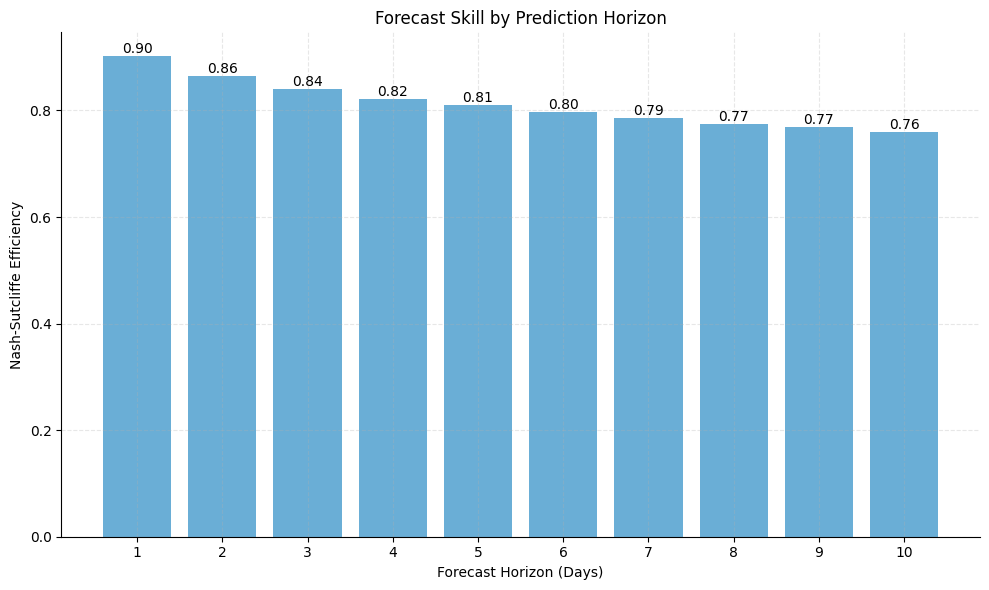

In [18]:
# Get the results
results_df = model.test_results["forecast_df"]
horizon_metrics = model.test_results["horizon_metrics"]

horizons = []
nse_values = []
for horizon, metrics in horizon_metrics.items():
    horizons.append(horizon)
    nse_values.append(metrics["NSE"])

# Create bar plot
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues", 1)
plt.bar(horizons, nse_values, color=colors)

# Customize plot
plt.xlabel("Forecast Horizon (Days)")
plt.ylabel("Nash-Sutcliffe Efficiency")
plt.title("Forecast Skill by Prediction Horizon")
plt.grid(True, linestyle="--", alpha=0.3)
sns.despine()

# Set x-axis ticks to show all horizons
plt.xticks(horizons)

# Add value labels on top of each bar
for i, v in enumerate(nse_values):
    plt.text(i + 1, v, f"{v:.2f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [19]:
results_df.head(10)

,horizon,prediction,observed,basin_id
0,1,1.219611,1.549368,CH_2009
1,2,1.799161,2.319609,CH_2009
2,3,2.001117,2.229560,CH_2009
3,4,2.033667,2.309961,CH_2009
4,5,2.061280,2.170063,CH_2009
5,6,1.925770,2.099310,CH_2009
6,7,1.623714,1.629769,CH_2009
7,8,1.351817,1.539720,CH_2009
8,9,1.824117,2.129863,CH_2009
9,10,2.078817,2.279408,CH_2009


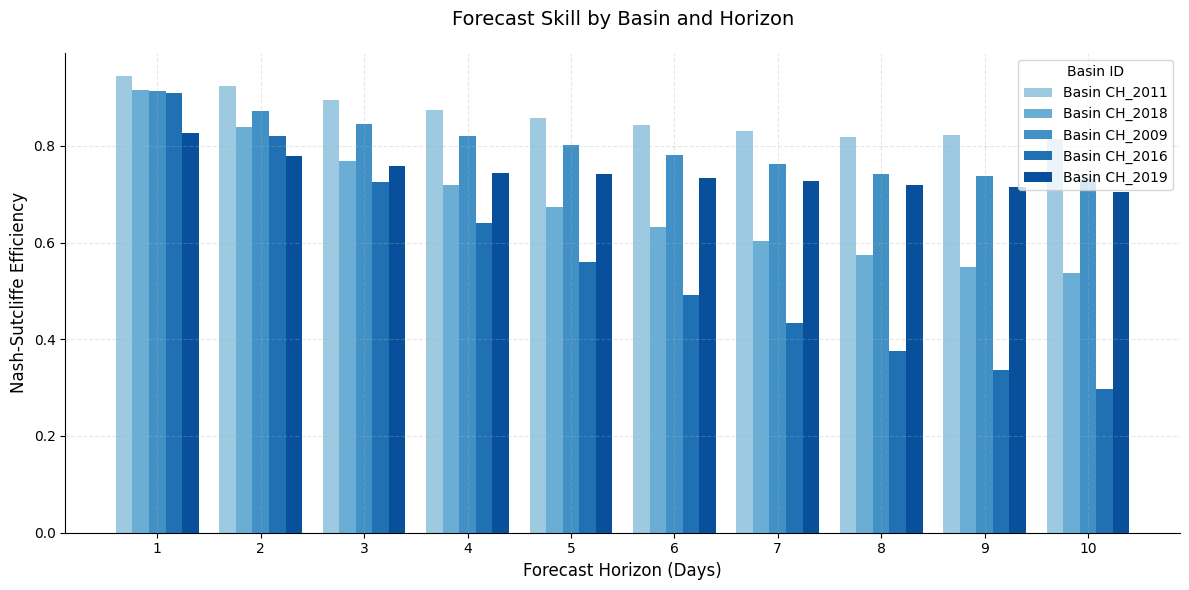

In [20]:
# Process results_df to get NSE by basin and horizon
basin_metrics = {}
for basin in results_df["basin_id"].unique():
    basin_data = results_df[results_df["basin_id"] == basin]
    nse_values = []
    for horizon in range(1, max(basin_data["horizon"]) + 1):
        horizon_data = basin_data[basin_data["horizon"] == horizon]
        nse = nash_sutcliffe_efficiency(
            horizon_data["observed"].values, horizon_data["prediction"].values
        )
        nse_values.append(nse)
    basin_metrics[basin] = nse_values

# Sort basins by NSE at horizon 1
sorted_basins = sorted(
    basin_metrics.keys(), key=lambda x: basin_metrics[x][0], reverse=True
)
basin_metrics = {basin: basin_metrics[basin] for basin in sorted_basins}

# Plot settings
plt.figure(figsize=(12, 6))
bar_width = 0.8 / len(basin_metrics)

# Create color palette of blue shades
colors = sns.color_palette("Blues", len(basin_metrics) + 2)[2:]

# Create bars for each basin
for i, (basin, nse_values) in enumerate(basin_metrics.items()):
    x = np.arange(len(nse_values)) + i * bar_width
    plt.bar(x, nse_values, bar_width, label=f"Basin {basin}", color=colors[i])

# Customize plot
plt.xlabel("Forecast Horizon (Days)", fontsize=12)
plt.ylabel("Nash-Sutcliffe Efficiency", fontsize=12)
plt.title("Forecast Skill by Basin and Horizon", fontsize=14, pad=20)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Basin ID", title_fontsize=10, fontsize=10)
sns.despine()

# Set x-axis ticks in middle of grouped bars
plt.xticks(
    np.arange(len(next(iter(basin_metrics.values()))))
    + bar_width * (len(basin_metrics) - 1) / 2,
    np.arange(1, len(next(iter(basin_metrics.values()))) + 1),
)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

In [21]:
bar_width

0.16

ZeroDivisionError: division by zero

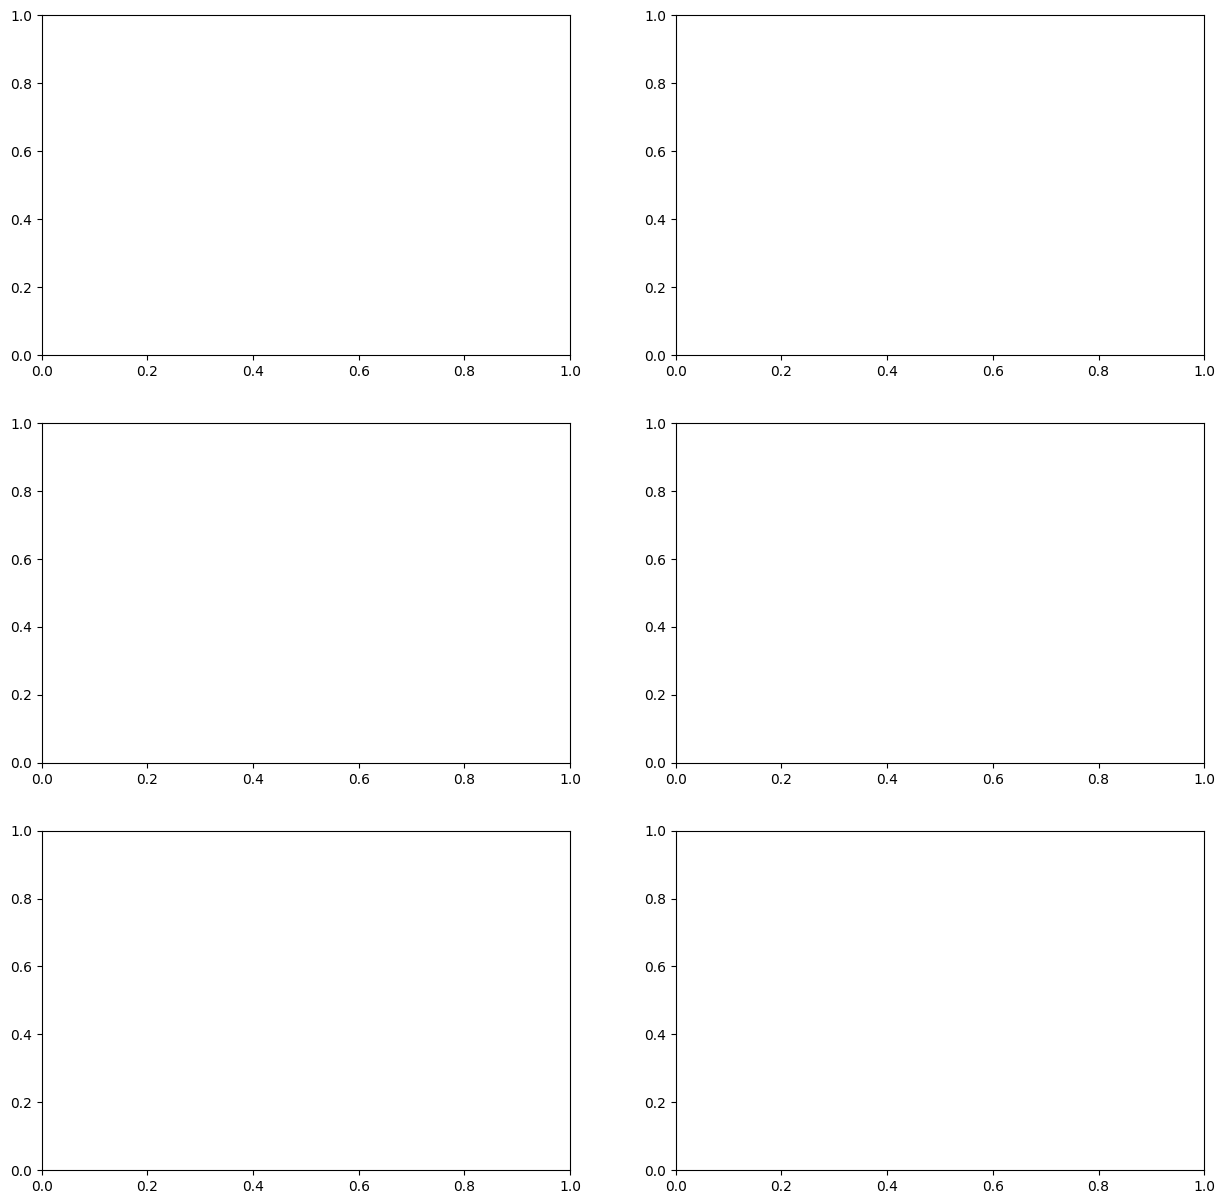

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_predictions(results_df, n_timesteps=None):
    # Filter for horizon 1
    horizon_1_data = results_df[results_df["horizon"] == 1]

    if n_timesteps:
        # Get last n_timesteps for each basin
        horizon_1_data = (
            horizon_1_data.groupby("basin_id").tail(n_timesteps).reset_index(drop=True)
        )

    n_basins = len(horizon_1_data["basin_id"].unique())
    n_cols = 2
    n_rows = (n_basins + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    # for idx, basin in enumerate(horizon_1_data["basin_id"].unique()):
    for idx, basin in enumerate(["CH_4011"]):
        basin_data = horizon_1_data[horizon_1_data["basin_id"] == basin]
        ax = axes[idx]

        nse = nash_sutcliffe_efficiency(
            basin_data["observed"].values, basin_data["prediction"].values
        )

        x = np.arange(len(basin_data))
        ax.plot(x, basin_data["observed"], label="Observed", color="#1d4ed8")
        ax.plot(
            x,
            basin_data["prediction"],
            label="Predicted",
            color="#dc2626",
            alpha=0.8,
        )

        ax.set_title(f"Basin {basin} (NSE: {nse:.3f})", fontsize=12)
        ax.set_xlabel("Time Step", fontsize=10)
        ax.set_ylabel("Discharge", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(fontsize=9)
        sns.despine(ax=ax)

    for idx in range(n_basins, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


# Example usage:
plot_predictions(results_df, n_timesteps=200) 

In [23]:
print("Test results available:", hasattr(model, 'test_results'))
if hasattr(model, 'test_results'):
    print("\nKeys in test_results:", model.test_results.keys())

Test results available: True

Keys in test_results: dict_keys(['forecast_df', 'horizon_metrics'])


In [24]:
def analyze_basin_data(forecast_df):
    for basin in forecast_df['basin_id'].unique():
        basin_data = forecast_df[forecast_df['basin_id'] == basin]
        
        # Check for gaps
        missing_mask = basin_data['observed'].isna() | basin_data['prediction'].isna()
        n_missing = missing_mask.sum()
        
        # Check for constant values
        obs_std = basin_data['observed'].std()
        
        print(f"\nBasin {basin}:")
        print(f"Total samples: {len(basin_data)}")
        print(f"Missing values: {n_missing}")
        print(f"Observed std: {obs_std:.6f}")
        if n_missing > 0:
            print("Gap locations:")
            gap_starts = basin_data[missing_mask]['horizon'].values
            for gap in gap_starts:
                print(f"  Horizon: {gap}")

analyze_basin_data(model.test_results['forecast_df'])


Basin CH_2009:
Total samples: 17880
Missing values: 0
Observed std: 1.633057

Basin CH_2011:
Total samples: 17880
Missing values: 0
Observed std: 2.009274

Basin CH_2016:
Total samples: 17880
Missing values: 0
Observed std: 1.009534

Basin CH_2018:
Total samples: 17880
Missing values: 0
Observed std: 1.744016

Basin CH_2019:
Total samples: 17880
Missing values: 0
Observed std: 3.616541


In [ ]:
test_results